In [1]:
import pickle
import pandas as pd
import numpy as np
from collections import defaultdict
from itertools import cycle

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, plot_roc_curve, roc_auc_score, auc
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from scipy.spatial import distance
from scipy.cluster import hierarchy
import umap
import umap.plot
import networkx as nx
import cs_umap_plot

import matplotlib.pyplot as plt
from bokeh.plotting import show, save, output_notebook, output_file
import seaborn as sns

import time
import datetime

print(datetime.datetime.now())

2022-06-17 11:50:03.807805


In [2]:
path_data = 'data/d20220201/'

# INPUTS
fn_finalSave = path_data + 'featuresAndMeta_s20220215.p'
fn_trainingResults = path_data + 'trainingResults_60_s20220302.p'
fn_featureImp_cont = path_data + 'featureImportance_continuous_s20220325'

# OUTPUTS
fn_featureImp = path_data + 'featureImportance_all_s20220302'
fn_featureImp_subset = path_data + 'featureImportance_subset_s20220302'

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['font.size'] = 10
plt.rcParams['figure.autolayout']=False

In [3]:
with open(fn_finalSave, "rb") as input_file:
    dict_data = pickle.load(input_file)

dict_data.keys()

dict_keys(['df_rawFeatures_training', 'df_rawFeatures_validation', 'dict_normalizationFactors', 'df_zscoreFeatures_training', 'df_zscoreFeatures_validation', 'df_metadata', 'umap_raw', 'umap_zscore'])

In [4]:
## number of features
dValue = 0.25

# dValue can be modified to retrieve more stringent or relaxed clusters (fewer clusters, increase number)
# 0.25 => 60 features

In [ ]:
dict_data['df_metadata']

In [6]:
# define current data
currFeatures = dict_data['df_zscoreFeatures_training']
tempMeta = dict_data['df_metadata']
currMeta = tempMeta[tempMeta.index.isin(currFeatures.index)]

toPredict_lre = currMeta[currMeta['decompBL']==True]['lre']
features_lre = currFeatures[currFeatures.index.isin(toPredict_lre.index)]

toPredict_lrd = currMeta[currMeta['lrd_tf']==True]['lrd']
features_lrd = currFeatures[currFeatures.index.isin(toPredict_lrd.index)]

toPredict_tfs = currMeta[currMeta['tfs_tf']==True]['tfs']
features_tfs = currFeatures[currFeatures.index.isin(toPredict_tfs.index)]

toPredict_survival = currMeta[currMeta['survival_tf']==True]['survival']
features_survival = currFeatures[currFeatures.index.isin(toPredict_survival.index)]

In [7]:
# define current data
currFeatures = dict_data['df_zscoreFeatures_validation']
tempMeta = dict_data['df_metadata']
currMeta = tempMeta[tempMeta.index.isin(currFeatures.index)]

toPredict_lre_test = currMeta[currMeta['decompBL']==True]['lre']
features_lre_test = currFeatures[currFeatures.index.isin(toPredict_lre_test.index)]

toPredict_lrd_test = currMeta[currMeta['lrd_tf']==True]['lrd']
features_lrd_test = currFeatures[currFeatures.index.isin(toPredict_lrd_test.index)]

toPredict_tfs_test = currMeta[currMeta['tfs_tf']==True]['tfs']
features_tfs_test = currFeatures[currFeatures.index.isin(toPredict_tfs_test.index)]

toPredict_survival_test = currMeta[currMeta['survival_tf']==True]['survival']
features_survival_test = currFeatures[currFeatures.index.isin(toPredict_survival_test.index)]

print(len(toPredict_lre_test))
print(len(toPredict_lrd_test))
print(len(toPredict_tfs_test))
print(len(toPredict_survival_test))

57
33
33
43


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


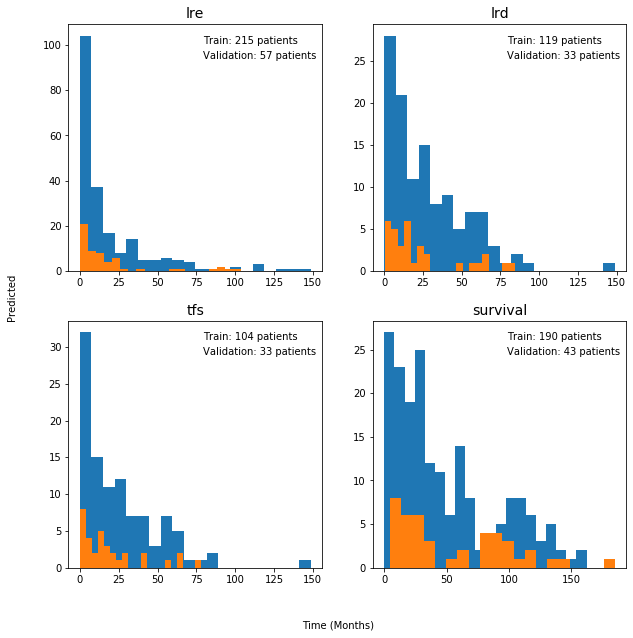

In [8]:
# keeping things organized
names = ['lre', 'lrd', 'tfs', 'survival']
featureSets = [features_lre, features_lrd, features_tfs, features_survival]
predictSets = [toPredict_lre, toPredict_lrd, toPredict_tfs, toPredict_survival]
featureSets_test = [features_lre_test, features_lrd_test, features_tfs_test, features_survival_test]
predictSets_test = [toPredict_lre_test, toPredict_lrd_test, toPredict_tfs_test, toPredict_survival_test]

fig, axs = plt.subplots(2,2,figsize=(10,10))
for eaName, eaFeature, eaPredict, eaAxs in zip(names, featureSets, predictSets, [axs[0][0], axs[0][1], axs[1][0], axs[1][1]]):
    eaAxs.hist(eaPredict, bins=20)
    eaAxs.title.set_text(eaName)
    annotext = "Train: " + str(len(eaPredict)) + " patients"
    eaAxs.annotate(annotext, xy=(0.53, 0.92), textcoords='axes fraction', horizontalalignment='left')
    
fig.text(0.5, 0.04, 'Time (Months)', ha='center')
fig.text(0.04, 0.5, 'Predicted', va='center', rotation='vertical')

for eaName, eaFeature, eaPredict, eaAxs in zip(names, featureSets_test, predictSets_test, [axs[0][0], axs[0][1], axs[1][0], axs[1][1]]):
    eaAxs.hist(eaPredict, bins=20)
    eaAxs.title.set_text(eaName)
    annotext = "Validation: " + str(len(eaPredict)) + " patients"
    eaAxs.annotate(annotext, xy=(0.53, 0.86), textcoords='axes fraction', horizontalalignment='left')

In [9]:
## identify redundant features

# retrieve clusters using fcluster 
df_featcorr = currFeatures.astype(float).corr(method='pearson')
d = hierarchy.distance.pdist(df_featcorr)
L = hierarchy.linkage(d, method='complete')
# dValue can be modified to retrieve more stringent or relaxed clusters (fewer clusters, increase number)
clusters = hierarchy.fcluster(L, dValue*d.max(), 'distance')

# store clusters in dictionary
featCluster_dict = defaultdict(list)
for i,cluster in enumerate(clusters):
    featCluster_dict[cluster].append(df_featcorr.index[i])

# currPlt = sns.clustermap(df_featcorr, row_linkage=L, col_linkage=L)

In [10]:
print('total # of features:')
print(len(clusters))
print('# features used for model training:')
print(len(featCluster_dict))

total # of features:
2436
# features used for model training:
71


In [11]:
# ## use feature permutation to identify most important feature of each cluster
# forest_importances = {}

# for eaName, eaFeature, eaPredict in zip(names, featureSets, predictSets):
#     rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
#     rf.fit(eaFeature, eaPredict); 
    
#     start_time = time.time()
#     result = permutation_importance(rf, eaFeature, eaPredict, n_repeats=10, random_state=42, n_jobs=-1)
    
#     elapsed_time = (time.time() - start_time) / 60
#     print(f"Elapsed time to compute the importances: {elapsed_time:.1f} minutes")

#     forest_importances[eaName] = pd.Series(result.importances_mean, index=eaFeature.columns)

In [12]:
with open(fn_featureImp_cont, "rb") as input_file:
    forest_importances = pickle.load(input_file)

forest_importances.keys()

dict_keys(['lre', 'lrd', 'tfs', 'survival'])

In [13]:
feat2keep = {'lre': [], 'lrd': [], 'tfs': [], 'survival': []}
featClusterOrder = {'lre': [], 'lrd': [], 'tfs': [], 'survival': []}

for eaCluster in featCluster_dict:
    currFeature_i = [currFeatures.columns.get_loc(c) for c in featCluster_dict[eaCluster]]
    for eaName, eaFeature in zip(names, featureSets):
        currImportances = [forest_importances[eaName][c] for c in currFeature_i]
        toKeep_i = currFeature_i[currImportances.index(max(currImportances))]
        feat2keep[eaName].append(currFeatures.columns[toKeep_i])
        featClusterOrder[eaName].append(eaCluster)

In [14]:
eaFeature

feature,original_shape_Elongation_liver,original_shape_Flatness_liver,original_shape_LeastAxisLength_liver,original_shape_MajorAxisLength_liver,original_shape_Maximum2DDiameterColumn_liver,original_shape_Maximum2DDiameterRow_liver,original_shape_Maximum2DDiameterSlice_liver,original_shape_Maximum3DDiameter_liver,original_shape_MeshVolume_liver,original_shape_MinorAxisLength_liver,...,wavelet-LLL_gldm_GrayLevelNonUniformity_spleen,wavelet-LLL_gldm_GrayLevelVariance_spleen,wavelet-LLL_gldm_HighGrayLevelEmphasis_spleen,wavelet-LLL_gldm_LargeDependenceEmphasis_spleen,wavelet-LLL_gldm_LargeDependenceHighGrayLevelEmphasis_spleen,wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmphasis_spleen,wavelet-LLL_gldm_LowGrayLevelEmphasis_spleen,wavelet-LLL_gldm_SmallDependenceEmphasis_spleen,wavelet-LLL_gldm_SmallDependenceHighGrayLevelEmphasis_spleen,wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis_spleen
0001,-2.08464,-1.4094,-1.67395,-0.277974,-3.13043,0.046931,-1.37827,-0.592282,-1.63322,-2.27789,...,3.33023,-0.301376,0.249605,1.31814,0.948518,-0.187091,-0.540164,-1.07394,-0.335506,-0.893683
0002,-0.861254,-1.45606,-1.65062,0.325096,-0.741276,-0.453968,0.405009,0.914123,-0.919716,-0.552609,...,-0.423589,0.323547,0.0990684,-1.51575,-0.32846,-0.877887,-0.630411,1.36822,0.484536,-0.331403
0004,0.113737,0.897042,0.748043,-0.229533,0.034784,-0.0921265,-0.360733,-0.213945,0.105918,-0.0368242,...,-0.0761159,-0.995994,-1.58462,0.922069,-1.32654,2.07736,2.31224,-1.20646,-1.33002,1.28071
0005,0.7545,1.7327,0.5137,-1.49891,-0.48089,-0.635486,-1.41674,-0.981159,-0.640536,-0.587567,...,-0.791933,0.223778,-0.732027,0.0608133,-0.540647,0.146233,0.572548,0.243719,-0.66268,1.65199
0006,-0.195143,1.00767,0.63432,-0.462332,-0.328225,0.0902974,-1.1443,-0.181358,-0.199893,-0.557547,...,0.138933,-0.292259,0.156821,0.134431,0.309219,-0.378997,-0.507673,-0.368652,-0.101702,-0.593877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0506,-0.257717,-0.853527,-0.466569,0.648094,0.69879,-0.520015,0.149635,0.137478,-0.0440549,0.318936,...,-0.301696,-0.296061,-0.9145,0.396228,-0.734288,0.548307,0.501456,-0.459622,-0.809006,0.385864
0507,-0.362399,0.323254,2.86837,2.59495,2.88202,2.24913,1.70595,2.65584,3.68061,2.06209,...,-0.676195,0.717573,-0.501113,-0.568953,-0.670298,-0.232311,0.174741,0.427708,-0.344704,0.582632
0509,-0.885078,-0.850536,-0.574451,0.323198,-0.180011,-0.5914,0.300528,-0.0274553,-1.06868,-0.498134,...,4.86446,-1.2265,-0.516288,1.902,0.463998,0.856123,0.0241917,-1.75494,-0.955464,-0.791541
0510,-0.027368,0.254931,0.360215,0.0330761,-0.679804,0.318463,0.470054,-0.0861664,0.0953623,0.0569785,...,3.73466,0.35438,0.727543,-0.142837,0.609916,-0.645006,-0.802108,-0.400723,0.370431,-1.0263


lre


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


lrd


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


tfs


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


survival


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


Text(0.04, 0.5, 'Predicted (Months)')

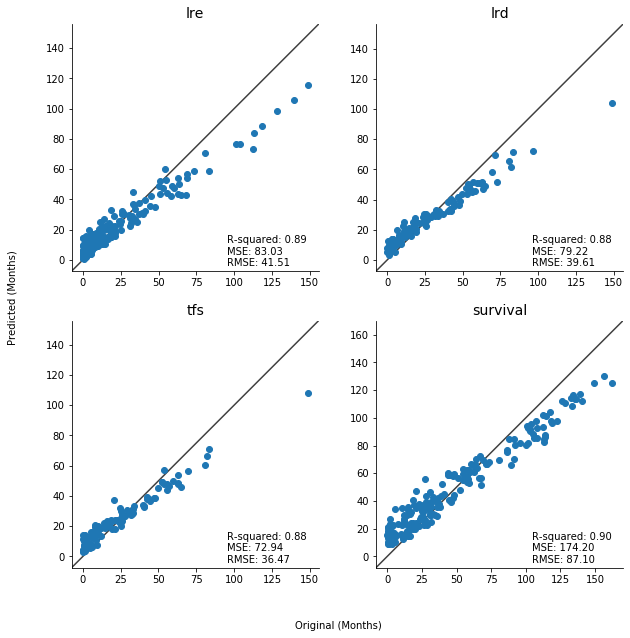

In [15]:
models = {}

fig, axs = plt.subplots(2,2,figsize=(10,10))
for eaName, eaFeature, eaPredict, eaAxs in zip(names, featureSets, predictSets, [axs[0][0], axs[0][1], axs[1][0], axs[1][1]]):
    features = eaFeature[feat2keep[eaName]]
    toPredict = eaPredict
    start_time = time.time()
    
    X_train, X_test, y_train, y_test = train_test_split(features, toPredict, test_size=0.2, random_state=1)

    rfr = RandomForestRegressor()
    rfr.fit(features, toPredict)

    #elapsed_time = (time.time() - start_time) / 60
    print(eaName)
    #print(f"Elapsed time to build RandomForestRegressor: {elapsed_time:.1f} minutes")
    
    score = rfr.score(features, toPredict)
    predicted = rfr.predict(features)
    mse = mean_squared_error(toPredict, predicted)
    
#     print("R-squared:", score)
#     print("MSE: ", mse)
#     print("RMSE: ", mse*(1/2.0))
    
    eaAxs.title.set_text(eaName)
    eaAxs.scatter(toPredict, predicted)
    
    # add scores
    scoreText = "R-squared: %.2f \nMSE: %.2f \nRMSE: %.2f" %(score,mse,mse*(1/2.0))
    eaAxs.annotate(scoreText, xy=(0.63, 0.02), textcoords='axes fraction', horizontalalignment='left')
    
    # add line
    lims = [
        np.min([eaAxs.get_xlim(), eaAxs.get_ylim()]),  # min of both axes
        np.max([eaAxs.get_xlim(), eaAxs.get_ylim()]),  # max of both axes
    ]
    eaAxs.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    eaAxs.set_aspect('equal')
    eaAxs.set_xlim(lims)
    eaAxs.set_ylim(lims)
    
    # make pretty
    eaAxs.spines['top'].set_visible(False)
    eaAxs.spines['right'].set_visible(False)

    models[eaName] = rfr

fig.text(0.5, 0.04, 'Original (Months)', ha='center')
fig.text(0.04, 0.5, 'Predicted (Months)', va='center', rotation='vertical')

lre


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


lrd


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


tfs


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


survival


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


Text(0.04, 0.5, 'Predicted (Months)')

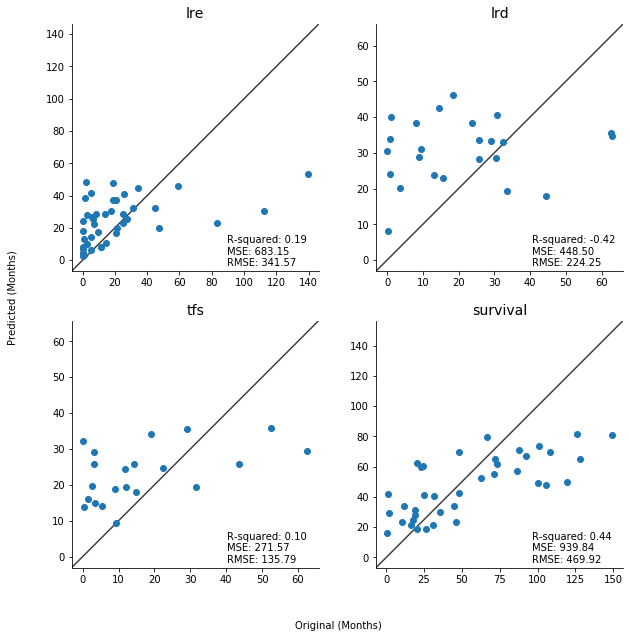

In [19]:
models = {}

fig, axs = plt.subplots(2,2,figsize=(10,10))
for eaName, eaFeature, eaPredict, eaAxs in zip(names, featureSets, predictSets, [axs[0][0], axs[0][1], axs[1][0], axs[1][1]]):
    features = eaFeature[feat2keep[eaName]]
    toPredict = eaPredict
    start_time = time.time()
    
    X_train, X_test, y_train, y_test = train_test_split(features, toPredict, test_size=0.2, random_state=1)

    rfr = RandomForestRegressor()
    rfr.fit(X_train, y_train)

    #elapsed_time = (time.time() - start_time) / 60
    print(eaName)
    #print(f"Elapsed time to build RandomForestRegressor: {elapsed_time:.1f} minutes")
    
    score = rfr.score(X_test, y_test)
    predicted = rfr.predict(X_test)
    mse = mean_squared_error(y_test, predicted)
    
#     print("R-squared:", score)
#     print("MSE: ", mse)
#     print("RMSE: ", mse*(1/2.0))
    
    eaAxs.title.set_text(eaName)
    eaAxs.scatter(y_test, predicted)
    
    # add scores
    scoreText = "R-squared: %.2f \nMSE: %.2f \nRMSE: %.2f" %(score,mse,mse*(1/2.0))
    eaAxs.annotate(scoreText, xy=(0.63, 0.02), textcoords='axes fraction', horizontalalignment='left')
    
    # add line
    lims = [
        np.min([eaAxs.get_xlim(), eaAxs.get_ylim()]),  # min of both axes
        np.max([eaAxs.get_xlim(), eaAxs.get_ylim()]),  # max of both axes
    ]
    eaAxs.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    eaAxs.set_aspect('equal')
    eaAxs.set_xlim(lims)
    eaAxs.set_ylim(lims)
    
    # make pretty
    eaAxs.spines['top'].set_visible(False)
    eaAxs.spines['right'].set_visible(False)

    models[eaName] = rfr

fig.text(0.5, 0.04, 'Original (Months)', ha='center')
fig.text(0.04, 0.5, 'Predicted (Months)', va='center', rotation='vertical')

R-squared: -1.3380907935771678
MSE:  1659.8602656059456
RMSE:  829.9301328029728
R-squared: -1.319575237728678
MSE:  1299.033382671488
RMSE:  649.516691335744
R-squared: -2.167352336644384
MSE:  1291.2429676543873
RMSE:  645.6214838271936
R-squared: 0.24076745846934478
MSE:  1508.1048473368921
RMSE:  754.0524236684461


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


Text(0.04, 0.5, 'Predicted')

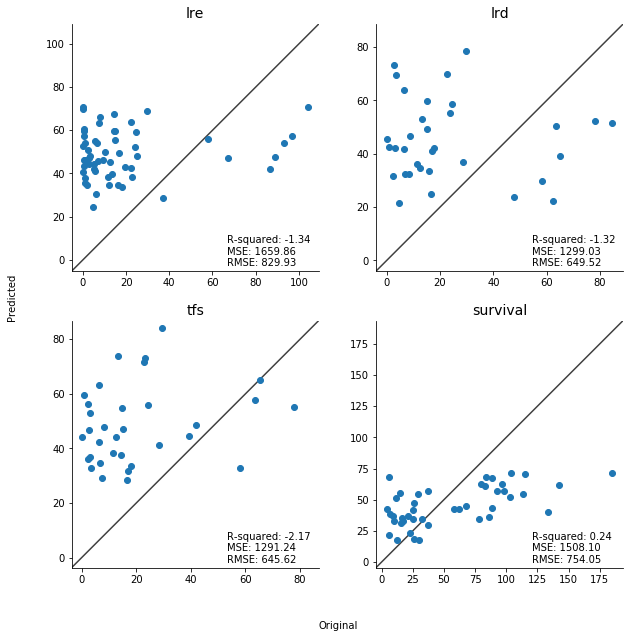

In [20]:
fig, axs = plt.subplots(2,2,figsize=(10,10))

for eaName, eaFeature, eaPredict, eaAxs in zip(names, featureSets_test, predictSets_test, [axs[0][0], axs[0][1], axs[1][0], axs[1][1]]):
    features = eaFeature[feat2keep[eaName]]
    toPredict = eaPredict
    currModel = models[eaName]
    
    score = rfr.score(features, toPredict)
    predicted = rfr.predict(features)
    mse = mean_squared_error(toPredict, predicted)
    
    print("R-squared:", score)
    print("MSE: ", mse)
    print("RMSE: ", mse*(1/2.0))
    
    eaAxs.title.set_text(eaName)
    eaAxs.scatter(toPredict, predicted)
    
    # add scores
    scoreText = "R-squared: %.2f \nMSE: %.2f \nRMSE: %.2f" %(score,mse,mse*(1/2.0))
    eaAxs.annotate(scoreText, xy=(0.63, 0.02), textcoords='axes fraction', horizontalalignment='left')
    
    # add line
    lims = [
        np.min([eaAxs.get_xlim(), eaAxs.get_ylim()]),  # min of both axes
        np.max([eaAxs.get_xlim(), eaAxs.get_ylim()]),  # max of both axes
    ]
    eaAxs.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    eaAxs.set_aspect('equal')
    eaAxs.set_xlim(lims)
    eaAxs.set_ylim(lims)
    
    # make pretty
    eaAxs.spines['top'].set_visible(False)
    eaAxs.spines['right'].set_visible(False)

fig.text(0.5, 0.04, 'Original', ha='center')
fig.text(0.04, 0.5, 'Predicted', va='center', rotation='vertical')


In [27]:
_ = tree.plot_tree(rf.estimators_[0], feature_names=X.columns, filled=True)

NameError: name 'rf' is not defined

In [17]:
print(datetime.datetime.now())

2022-06-17 11:50:17.396858
